In [94]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits import mplot3d
import itertools
import matplotlib

# View raw point data

In [95]:
with h5py.File('turf.h5', 'r') as fd:
    pts = fd['fields/coords'][:]
    attrs = dict(fd['fields'].attrs)
    grid_shape = attrs['grid_shape']
    grid_spacing = attrs['grid_spacing']
    grid_domain = attrs['grid_domain']

def plot3d():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.axes.set_xlim3d(left=-2, right=10)
    # ax.axes.set_ylim3d(bottom=0, top=10)
    # ax.axes.set_zlim3d(bottom=0, top=10)
    ax.set_xlabel('Axial (x)')
    ax.set_ylabel('Radial (y)')
    ax.set_zlabel('Transverse (z)')
    ax.xaxis.set_pane_color((1, 1, 1, 0))
    ax.yaxis.set_pane_color((1, 1, 1, 0))
    ax.zaxis.set_pane_color((1, 1, 1, 0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return fig, ax

Nx, Ny, Nz = 120, 100, 100
Ndomain = 8                      # Number of subdomains
Ndim = 3                         # Number of physical dimensions
sub_shape = (int(Nz/2), int(Ny/2), int(Nx/2))   # Subdomain shape
pts.shape

(150000, 3, 8)

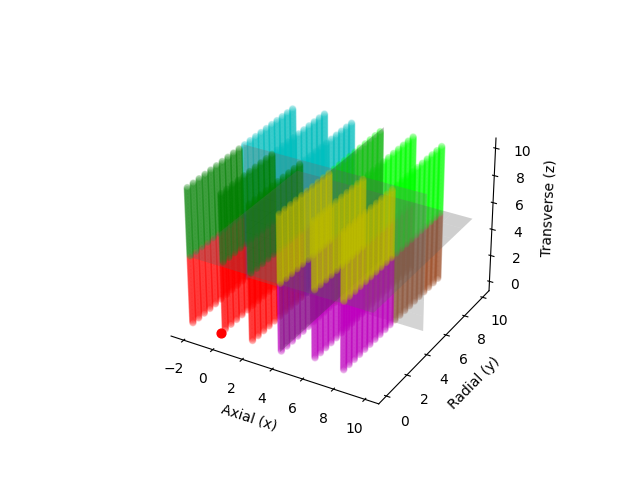

In [96]:
# Plot the 8 subdomains on one graph
fig, ax = plot3d()

# Gray dividing planes
X, Z = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, 5, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
Y, Z = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(4, Y, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
X, Y = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, Y, 5*np.ones(X.shape), color=(0.5, 0.5, 0.5), alpha=0.3)

# Thruster location
ax.scatter(0, 0, 0, color='r', s=40)

# Subdomains
skip = 100
sl = slice(0, pts.shape[0], skip)
c = ['r', 'g', 'b', 'c', 'm', 'y', 'sienna', 'lime']
labels = ['000', '001', '010', '011', '100', '101', '110', '111']
for i in range(pts.shape[-1]):
    ax.scatter(pts[sl, 0, i], pts[sl, 1, i], pts[sl, 2, i], color=c[i], label=labels[i], alpha=0.2)

In [97]:
# Stick the subdomains together
permute_axes = (2, 1, 0, 3, 4)                        # To go from (Z,Y,X,Ndim,Ndomain) to (X,Y,Z,Ndim,Ndomain)
pts3d = pts.reshape(sub_shape + (Ndim, Ndomain))      # This array comes out as (Z, Y, X, 3d, Ndomain)
pts3d = np.transpose(pts3d, axes=permute_axes)        # Now in the order (X,Y,Z, 3d, Ndomain)
Nx, Ny, Nz = 120, 100, 100
subdomains = list(itertools.product([0, 1], repeat=3))
pts_full = np.empty((Nx, Ny, Nz, 3))
sub_shape = (int(Nx/2), int(Ny/2), int(Nz/2))
for i, subdomain in enumerate(subdomains):
    xs, ys, zs = [ele * sub_shape[j] for j, ele in enumerate(subdomain)]
    xe, ye, ze = xs+int(Nx/2), ys+int(Ny/2), zs+int(Nz/2)  # 8 equal cube subdomains
    pts_full[xs:xe, ys:ye, zs:ze, :] = pts3d[..., i]

In [99]:
# Find the indices of nearest slice locations and plot
loc = [0, 4, 6]
axis = 1
slice_idx = []
domains = [(grid_domain[i, 0], grid_domain[i, 1]) for i in range(3)]  # For (x,y,z)
grids = [np.linspace(lb + grid_spacing[i]/2, ub - grid_spacing[i]/2, grid_shape[i])
         for i, (lb, ub) in enumerate(domains)]
slice_idx = [int(np.argmin(np.abs(grids[axis] - l))) for l in loc]
pts_slice = np.take(pts_full, slice_idx, axis=axis)

C:\Users\eckel\AppData\Local\Temp\ipykernel_1808\1911923728.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


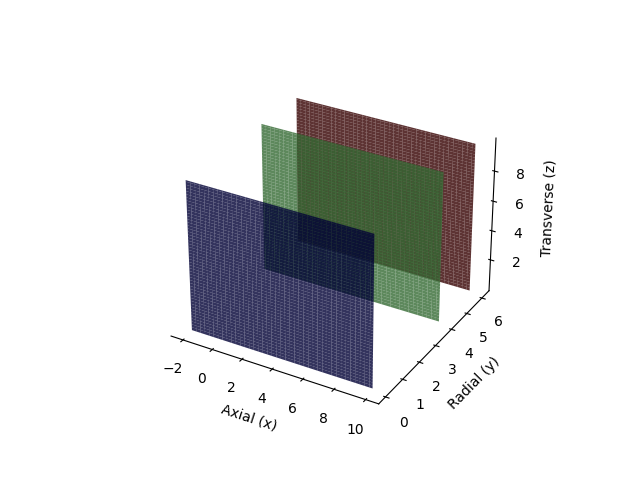

In [100]:
fig, ax = plot3d()
colors = plt.get_cmap('jet')(np.linspace(0, 1, len(slice_idx)))
for i in range(len(slice_idx)):
    X = np.take(pts_slice[..., 0], i, axis=axis)
    Y = np.take(pts_slice[..., 1], i, axis=axis)
    Z = np.take(pts_slice[..., 2], i, axis=axis)
    ax.plot_surface(X, Y, Z, color=colors[i], alpha=0.8)

# View ion velocity data

In [102]:
with h5py.File('turf.h5', 'r') as fd:
    qoi = fd['fields/ni'][:]  # (Npts, Ndomain, Nsave)
    Nsave = qoi.shape[-1]
sub_shape = (int(Nz/2), int(Ny/2), int(Nx/2))         # Subdomain shape
permute_axes = (2, 1, 0, 3, 4)                        # To go from (Z,Y,X,Ndim,Ndomain) to (X,Y,Z,Ndim,Ndomain)
qoi3d = qoi.reshape(sub_shape + (Ndomain, Nsave))     # This array comes out as (Z, Y, X, 3d, Ndomain)
qoi3d = np.transpose(qoi3d, axes=permute_axes)        # Now in the order (X,Y,Z, 3d, Ndomain)

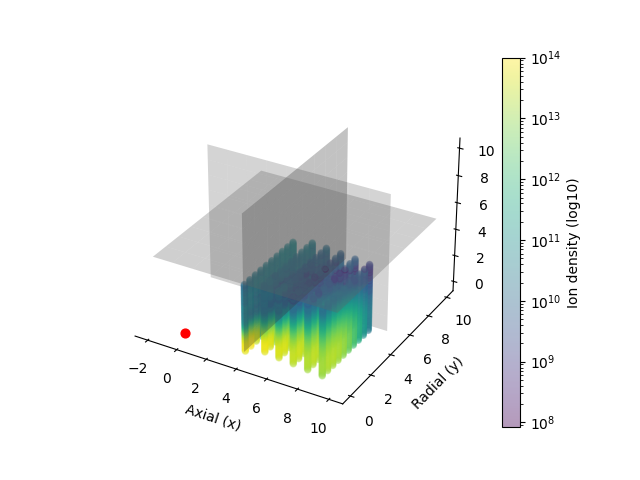

In [108]:
qoi_plot = np.mean(qoi[..., -20:], axis=-1)  # (Npts, Ndomain)

fig, ax = plot3d()
X, Z = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, 5, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
Y, Z = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(4, Y, Z, color=(0.5, 0.5, 0.5), alpha=0.3)
X, Y = np.meshgrid(np.linspace(-2, 10, 10), np.linspace(0, 10, 10))
ax.plot_surface(X, Y, 5*np.ones(X.shape), color=(0.5, 0.5, 0.5), alpha=0.3)
ax.scatter(0, 0, 0, color='r', s=40)

# Subdomains
skip = 50
sl = slice(0, pts.shape[0], skip)
c = ['r', 'g', 'b', 'c', 'm', 'y', 'sienna', 'lime']
labels = ['000', '001', '010', '011', '100', '101', '110', '111']
i = 4
sc = ax.scatter(pts[sl, 0, i], pts[sl, 1, i], pts[sl, 2, i], c=qoi_plot[sl, i], label=labels[i], alpha=0.4, cmap='viridis', norm='log')
cb = fig.colorbar(sc, label='Ion density (log10)')

In [109]:
Nx, Ny, Nz = 120, 100, 100
subdomains = list(itertools.product([0, 1], repeat=3))
qoi_full = np.empty((Nx, Ny, Nz))
sub_shape = (int(Nx/2), int(Ny/2), int(Nz/2))
for i, subdomain in enumerate(subdomains):
    xs, ys, zs = [ele * sub_shape[j] for j, ele in enumerate(subdomain)]
    xe, ye, ze = xs+int(Nx/2), ys+int(Ny/2), zs+int(Nz/2)  # 8 equal cube subdomains
    qoi_full[xs:xe, ys:ye, zs:ze] = np.mean(qoi3d[..., i, -20:], axis=-1)

In [110]:
loc = [0, 4, 6]
axis = 1
slice_idx = [int(np.argmin(np.abs(grids[axis] - l))) for l in loc]
pts_slice = np.take(pts_full, slice_idx, axis=axis)
qoi_slice = np.take(qoi_full, slice_idx, axis=axis)

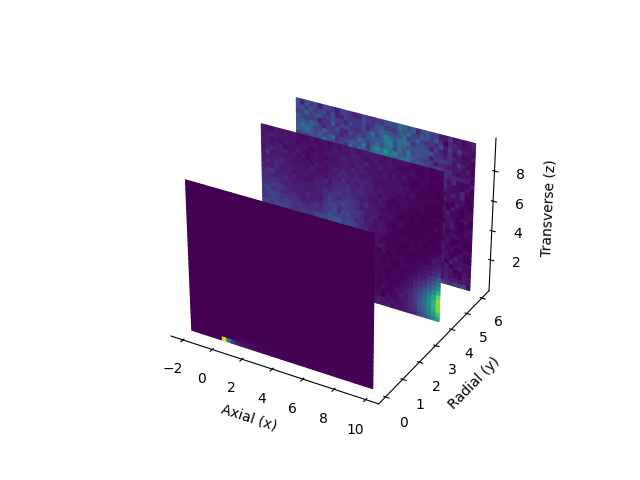

In [113]:
fig, ax = plot3d()
for i in range(len(slice_idx)):
    X = np.take(pts_slice[..., 0], i, axis=axis)
    Y = np.take(pts_slice[..., 1], i, axis=axis)
    Z = np.take(pts_slice[..., 2], i, axis=axis)
    C = np.take(qoi_slice, i, axis=axis)
    vmin, vmax = np.min(C), np.max(C)
    norm = matplotlib.colors.Normalize(vmin, vmax)
    m = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    m.set_array([])
    fcolors = m.to_rgba(C)
    ax.plot_surface(X, Y, Z, rcount=40, ccount=40, facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False)

In [133]:
pts_lst = pts_full.reshape((-1, 3))
qoi_lst = qoi_full.reshape((-1))
ix = np.random.choice(pts_lst.shape[0], size=10000, replace=False)

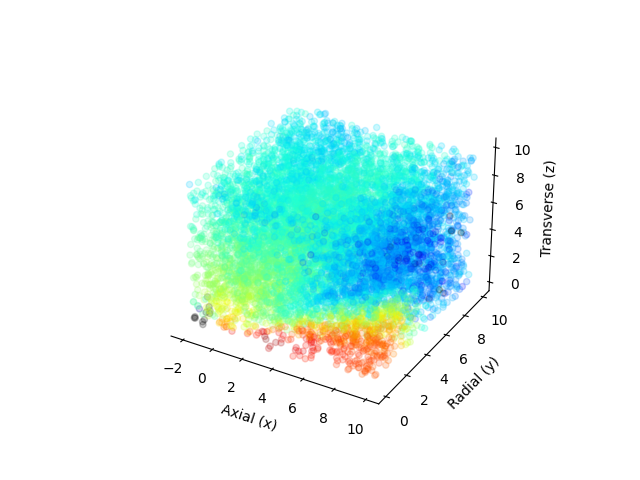

In [137]:
fig, ax = plot3d()
ax.scatter(pts_lst[ix, 0], pts_lst[ix, 1], pts_lst[ix, 2], c=qoi_lst[ix], alpha=0.2, cmap='jet', norm='log')

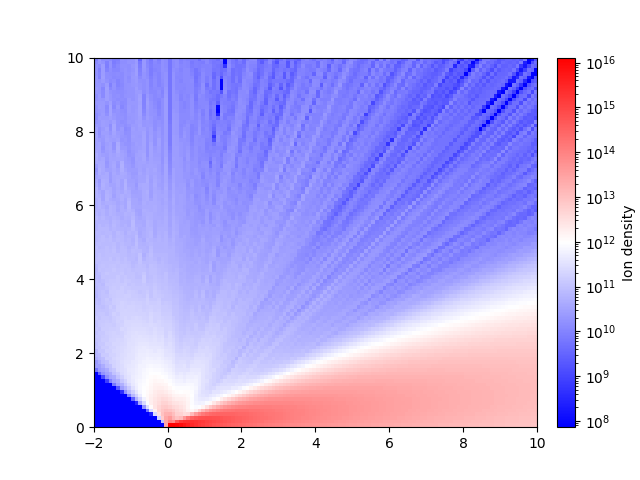

In [149]:
fig, ax = plt.subplots()
im = ax.imshow(qoi_slice[:, 0, :].T, cmap='bwr', origin='lower', extent=[-2, 10, 0, 10], norm='log', interpolation='nearest')
im.cmap.set_bad(im.cmap.get_under())
im.changed()
im_ratio = Nz / Nx
cb = fig.colorbar(im, label='Ion density', fraction=0.046*im_ratio, pad=0.04)